**Important - Do not use in production, for demonstration purposes only - please review the legal notices before continuing**

<p style="font-size:25px; color:black;"><b>Predicting the number of customers likely to visit different departments in a store</b></i></u></p>
<p style="font-size:16px; color:#117d30;">
    Time series forecasting is used on a model to predict future values based on previously observed values.
The AutoML feature of Azure ML, in this case uses more than 25 time series forecasting machine learning algorithms to predicts how many customers are likely to visit different departments in a store.

<p style="font-size:15px; color:#117d30;">
    <u> Abstract: </u>
</p>
</p>
<p style="font-size:16px; color:#117d30;">
1) Exploratory Data Analysis 
</p>
<p style="font-size:15px; color:#117d30;">
2) Training more than 25 time series forecasting machine learning algorithms.
</p>
<p style="font-size:15px; color:#117d30;">
3) Predict the number of customers likely to visit different departments in a store by choosing the best performing Machine Learning Algorithm.
</p>


## Introduction
<p style="font-size:16px; color:#117d30;">


### In this notebook we showcased how to:
<p style="font-size:16px; color:#117d30;">
1. Create an experiment using an existing workspace

<p style="font-size:16px; color:#117d30;">
2. Configure AutoML using 'AutoMLConfig'

<p style="font-size:16px; color:#117d30;">
3. Train the model 

<p style="font-size:16px; color:#117d30;">
4. Explore the engineered features and results

<p style="font-size:16px; color:#117d30;">
5. Configure and remote run AutoML for a time-series model with lag and rolling window features

<p style="font-size:16px; color:#117d30;">
6. Run and explore the forecast

<p style="font-size:16px; color:#117d30;">
7. Register the model





### Importing required libraries such as azureml, pandas, and other supporting libraries.



In [ ]:
#%pip install certifi==2022.9.24

In [1]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
import azureml.train.automl.runtime
import logging
import os, tempfile

from azureml.train.automl import AutoMLConfig
# from azureml.widgets import RunDetails
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model
from azureml.core.webservice import Webservice
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.environment import Environment

os.environ['AZURE_SERVICE']="Microsoft.ProjectArcadia"

## Loading Data

In [2]:
department_visits = pd.read_csv("department_visit_customer.csv")
department_visits.head()

,Date,Accessories_count,Entertainment_count,Gaming,Kids,Mens,Phone_and_GPS,Womens
0,08-06-2015,309,37,67,74,46,12,73
1,26-01-2020,367,20,32,73,56,88,98
2,21-10-2019,419,64,68,41,97,88,61
3,04-02-2019,481,46,91,96,75,92,81
4,16-04-2017,162,25,20,30,29,32,26


# Exploratory Data Analysis

<p style="font-size:16px; color:#117d30;">
The goal of performing exploratory data analysis is to understand the underlying patterns and correlations among features in the data. 


In [3]:
department_visit_data = department_visits
department_visit_data['Date'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%m/%d/%y')
department_visit_data['Month'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%m')
department_visit_data['DayOfMonth'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%d')
department_visit_data['Year'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%y')
department_visit_data['DayOfWeek'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%a')
department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']] = \
department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']].apply(pd.to_numeric)

department_visit_data.head()

,Date,Accessories_count,Entertainment_count,Gaming,Kids,Mens,Phone_and_GPS,Womens,Month,DayOfMonth,Year,DayOfWeek
0,08/06/15,309,37,67,74,46,12,73,08,06,15,Thu
1,01/26/20,367,20,32,73,56,88,98,01,26,20,Sun
2,10/21/19,419,64,68,41,97,88,61,10,21,19,Mon
3,04/02/19,481,46,91,96,75,92,81,04,02,19,Tue
4,04/16/17,162,25,20,30,29,32,26,04,16,17,Sun


##  Deriving insights from customer visits data  

<p style="font-size:16px; color:#117d30;">
1. Heat Map: Thickness of the color indicates the number of customers visiting that section of the store on that particular day. It provides a quick representation of distribution of traffic across days and in various departments. From the graph, we can infer that more number of customers visit the Entertainment department on Wednesdays, Thursdays and Fridays and there is less foot traffic on Mondays and Fridays in the Phone_and_gps department.


In [4]:
df_dow = department_visit_data.groupby('DayOfWeek').sum().sort_values(by = 'DayOfWeek', 
                                                                 ascending=True)
df_dow.head(10)

,Accessories_count,Entertainment_count,Gaming,Kids,Mens,Phone_and_GPS,Womens
DayOfWeek,,,,,,,
Fri,1735168,292512,291304,284494,289628,292888,284342
Mon,1654732,276280,276628,275770,275914,277680,272460
Sat,1671634,282086,275620,278434,278682,282354,274458
Sun,1641284,270682,272712,280374,272804,273192,271520
Thu,1696822,285508,282752,285338,281692,279558,281974
Tue,1709624,286698,285580,286570,280482,280896,289398
Wed,1762870,288616,292746,297100,291542,293844,299022


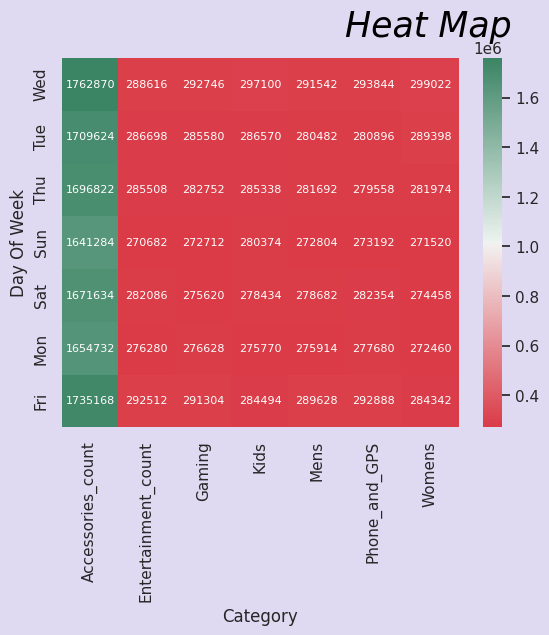

In [5]:
sns.set()
plt.rcParams['font.size'] = 12
bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
fig, ax = plt.subplots(1)
cmap = sns.diverging_palette(10, 150, n=2, as_cmap=True)
#cmap = sns.color_palette("hls", 150)

p = sns.heatmap(df_dow,
                cmap=cmap,
                annot=True,
                fmt="d",
                annot_kws={'size':8},
                ax=ax)
plt.xlabel('Category')
plt.ylabel('Day Of Week')
ax.set_ylim((0,7))
plt.text(5,7.4, "Heat Map", fontsize = 25, color='Black', fontstyle='italic')
 
plt.show()

# Data Manipulation  
<p style="font-size:16px; color:#117d30;">
1. Converting date to a specific format and making date fields relevant for prediction.

<p style="font-size:16px; color:#117d30;">
2. Converting the data type of the columns to numeric before being passed as input to the model.


In [6]:
department_visit_data = department_visits
department_visit_data['Date'] = pd.to_datetime(department_visit_data['Date']).dt.strftime('%Y-%m-%d')

department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']] = \
    department_visit_data[['Accessories_count','Entertainment_count','Gaming','Kids','Mens','Phone_and_GPS','Womens']].apply(pd.to_numeric)

grouped_data = department_visit_data.groupby('Date', as_index=False).sum()


total_rows = grouped_data.count
total_rows = grouped_data.count
total_rows

<bound method DataFrame.count of             Date  Accessories_count  Entertainment_count  Gaming  Kids  Mens  \
0     2014-12-31                812                  130      84   170   100   
1     2015-01-01               3498                  664     616   718   624   
2     2015-01-02               4090                  580     730   616   522   
3     2015-01-03               7446                 1264    1206  1102  1284   
4     2015-01-04               8152                 1248    1456  1394  1324   
...          ...                ...                  ...     ...   ...   ...   
2188  2020-12-27               5782                 1228     716  1180   898   
2189  2020-12-28               7810                 1468    1608   988  1280   
2190  2020-12-29               3846                  636     486   510   864   
2191  2020-12-30               3232                  572     394   528   562   
2192  2020-12-31               1308                  258     270   188   106   

      

In [7]:
accessories_data = grouped_data[['Date','Accessories_count']]
entertainment_data = grouped_data[['Date','Entertainment_count']]
gaming_data = grouped_data[['Date','Gaming']]
kids_data = grouped_data[['Date','Kids']]
mens_data = grouped_data[['Date','Mens']]
phone_and_GPS_data = grouped_data[['Date','Phone_and_GPS']]
womens_data = grouped_data[['Date','Womens']]

accessories_data['Department']='Accessories'
entertainment_data['Department']='Entertainment'
gaming_data['Department']='Gaming'
kids_data['Department']='Kids'
mens_data['Department']='Mens'
phone_and_GPS_data['Department']='Phone_and_GPS'
womens_data['Department']='Womens'

accessories_data= accessories_data.rename(columns={'Accessories_count': 'Visits'})
entertainment_data= entertainment_data.rename(columns={ 'Entertainment_count':'Visits'})
gaming_data = gaming_data.rename(columns={'Gaming': 'Visits'})
kids_data = kids_data.rename(columns={'Kids': 'Visits'})
mens_data = mens_data.rename(columns={'Mens': 'Visits'})
phone_and_GPS_data = phone_and_GPS_data.rename(columns={'Phone_and_GPS': 'Visits'})
womens_data = womens_data.rename(columns={'Womens': 'Visits'})
df_customervisits = accessories_data.append( entertainment_data).append(gaming_data).append(kids_data).append(mens_data).append(phone_and_GPS_data).append(womens_data)

df_customervisits

/tmp/ipykernel_26807/922381925.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accessories_data['Department']='Accessories'
/tmp/ipykernel_26807/922381925.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entertainment_data['Department']='Entertainment'
/tmp/ipykernel_26807/922381925.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,Date,Visits,Department
0,2014-12-31,812,Accessories
1,2015-01-01,3498,Accessories
2,2015-01-02,4090,Accessories
3,2015-01-03,7446,Accessories
4,2015-01-04,8152,Accessories
...,...,...,...
2188,2020-12-27,952,Womens
2189,2020-12-28,1188,Womens
2190,2020-12-29,604,Womens
2191,2020-12-30,712,Womens


In [8]:
total_rows = df_customervisits.count
total_rows

<bound method DataFrame.count of             Date  Visits   Department
0     2014-12-31     812  Accessories
1     2015-01-01    3498  Accessories
2     2015-01-02    4090  Accessories
3     2015-01-03    7446  Accessories
4     2015-01-04    8152  Accessories
...          ...     ...          ...
2188  2020-12-27     952       Womens
2189  2020-12-28    1188       Womens
2190  2020-12-29     604       Womens
2191  2020-12-30     712       Womens
2192  2020-12-31     262       Womens

[15351 rows x 3 columns]>

## Train

<p style="font-size:16px; color:#117d30;">
1. Instantiate an AutoMLConfig object. 
<p style="font-size:16px; color:#117d30;">
2. The configuration below defines the settings and data used to run the experiment. 


## Set AutoML Configuration Parameters

<p style="font-size:16px; color:#117d30;">
    The forecast horizon is the number of periods into the future that the model should predict. 

<p style="font-size:16px; color:#117d30;">
    It is generally recommended that users set forecast horizons to less than 100 time periods.

<p style="font-size:16px; color:#117d30;">
    Furthermore, AutoML's memory use and computation time increases in proportion to the length of the horizon, so consider carefully how this value is set. 

<p style="font-size:16px; color:#117d30;">
    If a long horizon forecast is absolutely necessary, consider aggregating the series to a coarser time scale.


In [11]:
#Azure ML
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = "Department_Visit_Count_Prediction"

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["SKU"] = ws.sku
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
output["SDK Version"] = azureml.core.VERSION
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,506e86fc-853c-4557-a6e5-ad72114efd2b
Workspace,amlws-midp
SKU,Basic
Resource Group,rg-midpwithazurecosmos-prod
Location,eastus2
Run History Name,Department_Visit_Count_Prediction
SDK Version,1.48.0


In [9]:
automl_settings = {
   'time_column_name':'Date',
   'grain_column_names': ['Department'],
   'max_horizon': 25
}

In [10]:
automl_config = AutoMLConfig( 
                            #forecasting for time-series tasks
                            task='forecasting',
                            #measuere for evaluating the performance of the models
                            primary_metric='normalized_root_mean_squared_error',
                            #Maximum amount of time in minutes that the experiment takes before it terminates.
                            experiment_timeout_minutes=15,
                            enable_early_stopping=True,
                            training_data=df_customervisits,#train_data,
                            label_column_name='Visits',
                            #Rolling Origin Validation is used to split time-series in a temporally consistent way.
                            n_cross_validations=4,
                            # Flag to enable early termination if the score is not improving in the short term.
                            enable_ensembling=False,
                            verbosity=logging.INFO,
                            **automl_settings)

## Run The Experiment
<p style="font-size:16px; color:#117d30;">
Automated ML runs more than 25 Machine Learning Algorithms and grades them according to performance.


In [12]:
model_name = "Department-Visits-Forecast-Model"
description = "Forecasting Machine Learning model to predict department visits"
tags = {'WWI': 'DepartmentVisitsPredictions'}


matching_models = Model.list(ws, model_name, latest=True)
if len(matching_models) > 0:
    run = AutoMLRun(experiment, matching_models[0].run_id)
    automl_run = AutoMLRun(experiment, run.parent.id)
    best_run, fitted_model = automl_run.get_output()
else:
    local_run = experiment.submit(automl_config, show_output=True)
    best_run, fitted_model = local_run.get_output()
    model = local_run.register_model(model_name=model_name, description = description, tags = tags)

fitted_model

No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
Department_Visit_Count_Prediction,AutoML_e5baf738-669c-44f1-8d32-ad04234b05b3,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:   

2023/02/02 16:40:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
                                             steps=[('timeseriestransformer',
                                                     TimeSeriesTransformer(country_or_region=None, drop_column_names=[], featurization_config=FeaturizationConfig(blocked_transformers=None, column_purposes=None, dataset_language=None, prediction_transform_type=None, transformer_params=None), force_time_index_features=Non...
                                                     ProphetModel(prophet_param_dict={'uncertainty_samples': 0}, timeseries_param_dict={'time_column_name': 'Date', 'grain_column_names': ['Department'], 'target_column_name': 'Visits', 'drop_column_names': [], 'overwrite_columns': True, 'dropna': False, 'transform_dictionary': {'min': '_automl_target_col', 'max': '_automl_target_col', 'mean': '_automl_target_col'}, 'max_horizon': 25, 'origin_time_colname': 'origin', 'country_or_region': None, 'n_cross_validations': 4, 'short_series_han

In [13]:
#future_date =  pd.date_range(start='2015-12-1', end='2015-12-5')
#future_data = pd.DataFrame({'Date':future_date, 'Department':'Accessories', 'Visits':0})

future_date =  pd.date_range(start='2021-01-01', end='2021-01-20').values
future_data = pd.DataFrame({'Date':future_date, 'Department':'Womens'})
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Mens'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Entertainment'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Gaming'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Kids'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Accessories'}), ignore_index=True)
future_data = future_data.append(pd.DataFrame({'Date':future_date, 'Department':'Phone_and_GPS'}), ignore_index=True)

future_data

,Date,Department
0,2021-01-01,Womens
1,2021-01-02,Womens
2,2021-01-03,Womens
3,2021-01-04,Womens
4,2021-01-05,Womens
...,...,...
135,2021-01-16,Phone_and_GPS
136,2021-01-17,Phone_and_GPS
137,2021-01-18,Phone_and_GPS
138,2021-01-19,Phone_and_GPS


## Making future prediction using model that performs best


In [14]:
y_predictions, X_trans = fitted_model.forecast(future_data)
X_trans.reset_index(inplace=True)
X_trans

,Date,Department,_automl_target_col_WASNULL,grain_Department,_automl_year,_automl_half,_automl_quarter,_automl_month,_automl_day,_automl_wday,_automl_qday,_automl_week,_automl_target_col
0,2021-01-01,Womens,0,6,2021,1,1,1,1,4,1,53,878.37
1,2021-01-02,Womens,0,6,2021,1,1,1,2,5,2,53,850.93
2,2021-01-03,Womens,0,6,2021,1,1,1,3,6,3,53,845.81
3,2021-01-04,Womens,0,6,2021,1,1,1,4,0,4,1,853.16
4,2021-01-05,Womens,0,6,2021,1,1,1,5,1,5,1,911.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2021-01-16,Phone_and_GPS,0,5,2021,1,1,1,16,5,16,2,879.16
136,2021-01-17,Phone_and_GPS,0,5,2021,1,1,1,17,6,17,2,850.55
137,2021-01-18,Phone_and_GPS,0,5,2021,1,1,1,18,0,18,3,865.94
138,2021-01-19,Phone_and_GPS,0,5,2021,1,1,1,19,1,19,3,877.64


In [15]:
table = pd.pivot_table(X_trans, values=['_automl_target_col'], index=['Date'], columns=['Department'])
#table['Date'] = table.index
table.columns = table.columns.droplevel()
table.reset_index(inplace=True)

table = table.astype({'Accessories': 'int32','Entertainment': 'int32','Gaming': 'int32','Kids': 'int32','Mens': 'int32','Phone_and_GPS': 'int32','Womens': 'int32'}, copy=False)

table.head(100)

Department,Date,Accessories,Entertainment,Gaming,Kids,Mens,Phone_and_GPS,Womens
0,2021-01-01,5406,942,894,860,912,918,878
1,2021-01-02,5212,906,847,843,880,885,850
2,2021-01-03,5123,866,840,851,864,855,845
3,2021-01-04,5172,879,855,837,877,870,853
4,2021-01-05,5353,908,885,873,894,879,911
5,2021-01-06,5510,907,906,905,929,917,943
6,2021-01-07,5302,893,876,868,900,871,893
7,2021-01-08,5444,914,906,869,930,916,908
8,2021-01-09,5243,877,856,850,897,881,881
9,2021-01-10,5148,838,847,856,879,851,875


In [16]:
predict_df = pd.DataFrame(table, ['Date', 'Accessories', 'Entertainment', 'Gaming', 'Kids', 'Mens', 'Phone_and_GPS', 'Womens'])
predict_df.to_csv('dept_visit_customer_prediction.csv', index = False)